### Eager Execution

#### 1.X 版本

我们要构建好计算图 graph 后，再用 session 来执行 graph。即 Graph Execution。

#### 2.X 版本

2.X 的代码不需要 session 了，可以像编写普通的 Python 代码一样立即执行。即 Eager Execution。

In [2]:
# 导入 1.X 版本
import tensorflow.compat.v1 as tfv1
tfv1.compat.v1.enable_eager_execution();

# 导入 2.X 版本
import tensorflow as tf

import numpy as np
import timeit
from datetime import datetime

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# 1.X 版本代码
g = tfv1.Graph()
with g.as_default():
    y_hat = tfv1.constant(36, name='y_hat')
    y = tfv1.constant(39, name='y')
    loss = tfv1.Variable((y-y_hat)**2, name='loss')

with tfv1.Session(graph=g) as sess:
    init = tfv1.global_variables_initializer()
    sess.run(init)
    result = sess.run(loss)
    print(result)

9


In [6]:
# 2.X 版本代码

y_hat_2 = tf.constant(36)
y_2 = tf.constant(39)

loss2 = tf.Variable((y_2 - y_hat_2)**2)
print(loss2.numpy())

9


### 引入了 tf.function

2.x的Eager模式有许多优点，例如代码简洁，还有就是能立即执行立即返回结果，从而使调式代码时也变得更轻松.....但是eager模式也有缺点，那就是代码的运行效率没有graph模式的高。

因为graph模式是将大量操作构建成一个graph后再一致性执行的，所以执行效率要高。为了兼顾eager模式的开发便利和graph模式的运行高效，2.x引入了tf.function。

通过tf.function可以将eager模式下的代码转换成graph模式，也就是说，我们在eager模式下编写代码然后在graph模式下运行代码。

In [4]:
# 定义一个 Python function
def a_regular_function(x, y, b):
    x = tf.matmul(x, y)
    x = x + b
    return x

# `a_function_that_use_a_graph` 是一个 Tensorflow `Function`
a_function_that_use_a_graph = tf.function(a_regular_function)

x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)

orig_value = a_regular_function(x1, y1, b1).numpy()
tf_function_value = a_function_that_use_a_graph(x1, y1, b1).numpy()

assert(orig_value == tf_function_value)
print(orig_value)
print(tf_function_value)

[[12.]]
[[12.]]


In [5]:
# 测试 tf.function 提升效率

x = tf.random.uniform(shape=[10, 10], minval=-1, maxval=2, dtype=tf.dtypes.int32)

def power(x, y):
    result = tf.eye(10, dtype=tf.dtypes.int32)
    for _ in range(y):
        result = tf.matmul(x, result)
    return result

print("Eager execution:", timeit.timeit(lambda: power(x, 100), number=1000))

power_as_graph = tf.function(power)
print("Graph execution:", timeit.timeit(lambda: power_as_graph(x, 100), number=1000))

Eager execution: 1.878658000001451
Graph execution: 0.6283134999976028


tf.function不仅仅只作用于顶层的python function，它也作用于内嵌的python function。

In [6]:
def inner_function(x, y, b):
    x = tf.matmul(x, y)
    x = x + b
    return x

# 把 tf.function 当作修饰符来用
@tf.function
def outer_function(x):
    y = tf.constant([[2.0], [3.0]])
    b = tf.constant(4.0)

    return inner_function(x, y, b)

outer_function(tf.constant([[1.0, 2.0]])).numpy()

array([[12.]], dtype=float32)

### 构建模型的三种方式

- Sequential Model
- Functional API
- Subclassing Model

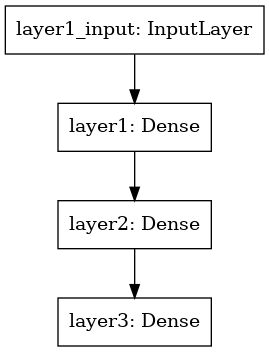

In [8]:
# 用 Sequential model 的方式构建一个模型

model = keras.Sequential(
    [
        layers.Dense(2, activation='relu', name='layer1'),
        layers.Dense(3, activation='relu', name='layer2'),
        layers.Dense(4, name='layer3')
    ]
)
x = tf.ones((3, 3))
y = model(x)

keras.utils.plot_model(model, "Sequential_model.png")

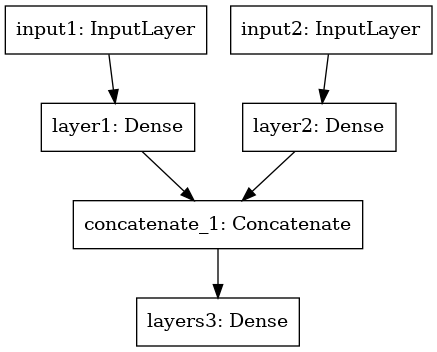

In [10]:
# 用 Function API 方式构建模型

input1 = keras.Input(shape=(3,3), name='input1')
input2 = keras.Input(shape=(3,3), name='input2')
layer1 = layers.Dense(2, activation='relu', name='layer1')(input1)
layer2 = layers.Dense(2, activation='relu', name='layer2')(input2)
x= layers.concatenate([layer1, layer2])
layer3 = layers.Dense(4, name='layers3')(x)
model = keras.Model(
    inputs=[input1, input2],
    outputs=[layer3]
)
keras.utils.plot_model(model, 'Functional API.png')

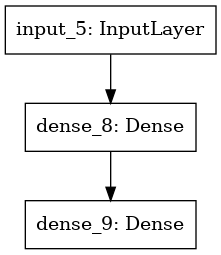

In [15]:
# 使用 Functional API 构建的一个简单模型
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)

keras.utils.plot_model(mlp, 'Function API simple.png')

In [18]:
# 使用 subclassing 方式实现上述模型
class MLP(keras.Model):
    def __init__(self, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dense_1 = layers.Dense(64, activation='relu')
        self.dense_2 = layers.Dense(10)
    
    def call(self, inputs):
        x = self.dense_1(inputs)
        return self.dense_2(x)

# 实例化模型
mlp = MLP()
_ = mlp(tf.zeros((1, 32)))

In [19]:
# 混合使用 Functional API 和 Subclassing

units = 32
timesteps= 10
input_dim = 5

# 用 Functional API 的方式构建一个模型
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# 用 Subclassing 的方式构建另一个模型
class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation='tanh')
        self.projection_2 = layers.Dense(units=units, activation='tanh')
        # 在这里调用之前用 Functional API 构建的模型
        self.classifier = model
    
    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)
